In [1]:
import logging
import whisper
import os
import time
from yt_dlp import YoutubeDL
import matplotlib.pyplot as plt

youtubeVideotestURL = 'http://www.youtube.com/watch?v=4FTIVJEBkNY'

# 1. Extracting audio from the video

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def download_audio_ytdlp(youtube_url, output_path="audio.mp3"):
    # Define download options
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [
            {   
                'key': 'FFmpegExtractAudio',
                'preferredcodec': 'mp3',
                'preferredquality': '192',
            }
        ],
        'ffmpeg-location': '/usr/bin/ffmpeg',
        'outtmpl': 'audio.%(ext)s',  # Save as 'audio.ext'
    }
    
    # Download the audio
    with YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])
    
    # Ensure the output file exists
    if not os.path.exists("audio.mp3"):
        raise FileNotFoundError("Audio file not found!")
    
    return output_path


start_time = time.time()
download_audio_ytdlp(youtubeVideotestURL)
end_time = time.time()

time_dict = {"Downloading audio": end_time - start_time}
logger.info(f"Time taken for step 1: {time_dict['Downloading audio']:.1f} seconds")

[youtube] Extracting URL: http://www.youtube.com/watch?v=4FTIVJEBkNY
[youtube] 4FTIVJEBkNY: Downloading webpage
[youtube] 4FTIVJEBkNY: Downloading tv player API JSON
[youtube] 4FTIVJEBkNY: Downloading ios player API JSON
[youtube] 4FTIVJEBkNY: Downloading m3u8 information
[info] 4FTIVJEBkNY: Downloading 1 format(s): 251
[download] Destination: audio.webm
[download] 100% of    9.53MiB in 00:00:00 at 15.64MiB/s    
[ExtractAudio] Destination: audio.mp3
Deleting original file audio.webm (pass -k to keep)


2025-01-22 17:46:21,145 - INFO - Time taken for step 1: 26.8 seconds


# 2. Transcribing the audio file

In [3]:
audio_path = "audio.mp3"

def transcribe_audio(audio_path, model_name="base"):
    logger.info(f"Loading Whisper model: {model_name}")
    model = whisper.load_model(model_name, download_root=None, in_memory=True)

    model_size = sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # size in MB
    logger.info(f"Model loaded into memory. Size: {model_size:.2f} MB")
    logger.info(f"Transcribing audio file: {audio_path}")
    result = model.transcribe(audio_path)
    
    logger.info("Transcription completed successfully")
    return result["text"]


if os.path.exists(audio_path):
    logger.info(f"Audio file found: {audio_path}")

    start_time = time.time()
    transcription = transcribe_audio(audio_path)
    end_time = time.time()
    
    time_dict["Transcritping audio with Whisper"] = end_time - start_time
    with open("transcription.txt", "w") as f:
        f.write(transcription)
    logger.info("Transcription saved to transcription.txt")
    logger.info(f"Transcription: {transcription}")
    logger.info(f"Time taken for step 2: {time_dict['Transcritping audio with Whisper']:.1f} seconds")
else:
    logger.error(f"Audio file not found: {audio_path}")

2025-01-22 17:46:21,157 - INFO - Audio file found: audio.mp3
2025-01-22 17:46:21,158 - INFO - Loading Whisper model: base
/home/thibaud/Documents/travail/youtube-summarizer/venv/lib/python3.12/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control o

# 3. Creating chunks from the audio file

This step ensures the summarization LLM is fed bite-sized chunks of data, and context is kept throughout the extraction for any video size or length

In [4]:
with open("transcription.txt", "r") as file:
    transcription = file.read()

def chunk_text(text, chunk_size=3000):
    sentences = text.split('. ')
    chunk = []
    current_length = 0

    for sentence in sentences:
        sentence_length = len(sentence) + 2  # account for the period and space
        if current_length + sentence_length > chunk_size:
            yield '. '.join(chunk) + '.'
            chunk = []
            current_length = 0
        chunk.append(sentence)
        current_length += sentence_length

    if chunk:
        yield '. '.join(chunk) + '.'

start_time = time.time()
chunks = list(chunk_text(transcription))

# Create the directory if it doesn't exist
os.makedirs("chunks", exist_ok=True)

for i, chunk in enumerate(chunks, start=1):
    with open(f"chunks/chunk_{i}.txt", "w") as f:
        f.write(chunk)

end_time = time.time()

time_dict["Chunking transcript"] = end_time - start_time
logger.info(f"Time taken for step 3: {time_dict['Chunking transcript']:.1f} seconds")

2025-01-22 17:48:00,314 - INFO - Time taken for step 3: 0.0 seconds


# 4. Extracting key elements from each chunk
We feed each chunk to the LLM, and each chunk's transcription text is summarized in bullet points. Each chunk's bullet points are then combined in a single text file

In [5]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate
model = OllamaLLM(model="mistral")

template = """
[SYSTEM MESSAGE]
You are a helpful assistant that extracts key points from user-provided text. Extract concise bullet points representing the key ideas. You can have 3-7 bullet points per chun, no more. In your answer, do not give numbers to bullet points. 
No extra commentary. Just the 3-7 key points.

[USER MESSAGE]
{chunkText}
"""

prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model

In [6]:
chunk_files = sorted([f for f in os.listdir("chunks") if f.startswith("chunk_") and f.endswith(".txt")])
# Delete the bulletPoints.txt file if it exists to reset it between each run
if os.path.exists("bulletPoints.txt"):
    os.remove("bulletPoints.txt")


start_time = time.time()

for chunk_file in chunk_files:
    with open(os.path.join("chunks", chunk_file), "r") as file:
        chunk_text = file.read()
        result = chain.invoke({"chunkText": chunk_text})
        with open("bulletPoints.txt", "a") as bullet_file:
            bullet_file.write(f"{result}\n")
            print(f"Chunk {chunk_file} processed successfully : \n {result} \n\n")

end_time = time.time()
time_dict["Extracting Bullet Points with Mistral"] = end_time - start_time

logger.info(f"Time taken for step 4: {time_dict['Extracting Bullet Points with Mistral']:.1f} seconds")

2025-01-22 17:48:04,608 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


Chunk chunk_1.txt processed successfully : 
 1. The text is about Saint Laurent Island in Alaska, located near Gambel and the Bering Sea.
  2. Two Russian citizens arrived on a small boat in October 2022 seeking asylum in the United States, fleeing Russia due to Vladimir Putin's order of mobilization for war in Ukraine.
  3. The island is approximately 65 km from Russian coast and is the closest point where Russia and the United States are geographically close.
  4. The Bering Strait separates Chukotka, an autonomous region in Russia, and Alaska, a state in the United States.
  5. The two Diomede Islands, only 3 km apart, with the smaller Diomede being American and inhabited by a hundred people, and the larger Diomede, Russian and uninhabited since the USSR established a military base there in 1948.
  6. The Bering Strait is strategically important as it connects the Arctic and Pacific Oceans.
  7. Historically, the Bering Strait was significant for Russian trade colonies in Alaska and

2025-01-22 17:48:16,291 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


Chunk chunk_2.txt processed successfully : 
 1. In April 2014 to 2018, the Strait was free of ice for the first time since observations began.
2. Climate change is accelerating in the Arctic four times faster than on the rest of the planet.
3. The Arctic ice has lost about 40% of its surface area over the past 40 years and could entirely disappear during summer months by 2035.
4. The Strait, which was covered with ice for six months per year in the 1980s, is now navigable throughout winter.
5. A new commercial route, the Northeast Route, is emerging between Pacific and European ports.
6. This route could reduce shipping distance from Shanghai to Rotterdam by 15,790 km compared to the traditional route through the Strait of Malacca and Suez Canal (19,550 km).
7. The opening of the Strait to regular navigation could also connect the west coast of the United States to Europe via the Northwest Route, reducing distance from Hamburg to 12,770 km compared to the Panama Canal route (17,100 km)

2025-01-22 17:48:35,425 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


Chunk chunk_3.txt processed successfully : 
 1. Zones Economiques Exclusives (ZEE) extend 200 nautical miles from a country's coast, but can be extended to 350,000 nautical miles if a country proves its continental shelf continues beyond that point.
2. Dispute over the extension of the continental shelf: Russia vs Canada and Denmark over the Kara Sea (Orsale Lomonosoph) with significant hydrocarbon resources.
3. Diplomatic provocations due to territorial claims without international agreements.
4. In 2007, Russia planted a flag at 4600 meters under the Arctic Ocean near the North Pole.
5. Mourmansk is the most populous city north of the Arctic Circle with 280,000 inhabitants.
6. Mourmansk's port operates year-round due to the passage of the North Atlantic Drift (NAD), a warm ocean current.
7. Mourmansk serves as Russia's gateway to the Arctic and its natural resources, with key industries including fishing, nuclear-powered icebreaker fleet, and potential hub for LNG exports to Europe a

2025-01-22 17:48:47,170 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:48:54,292 - INFO - Time taken for step 4: 53.3 seconds


Chunk chunk_4.txt processed successfully : 
 1. Base houses two-thirds of Russian Submarines and an airbase at Olénya, with 25,000 to 30,000 soldiers stationed permanently.
    2. US is expanding the port of Nôme to monitor Bering Strait approach.
    3. F-35 fighters relocated to Fairbanks airbase and anti-missile base at Delta Junction.
    4. Abandoned US military base in Greenland is key to their anti-missile system again.
    5. Sweden joined NATO in autumn 2023 and 2024, increasing strategic Arctic tension between Russia and Western powers.
    6. Russia and China see strategic interest in the Arctic due to warming, allowing for a Northern route avoiding Suez and Malacca congestion.
    7. China, although located 1500 km from the Arctic Circle, is equipping penguins, operating vessels in Arctic waters, and cooperating with Russia in the region (Sinorus). 




(Optionnal : With Mistral we need to format each line. Not a fast implementation but a very simple one for Proof Of Work purposes. Prompt engineering in the summarization prompt should remove the useless numbers
Asking an LLM to do this step is slow, but resilient to text formatting output variations from the previous LLM call.)

In [7]:
cleaning_template = """
[SYSTEM MESSAGE]
You are a helpful assistant that processes text lines. You remove the beginning number (like '1.' '2.') and any indentation from the text. If there's no number, do nothing. Return only the cleaned text. No additional commentary.

[USER MESSAGE]
{line}
"""


cleaning_prompt = ChatPromptTemplate.from_template(cleaning_template)
cleaning_chain = cleaning_prompt | model

start_time = time.time()

with open("bulletPoints.txt", "r") as infile, open("bulletPointsCleaned.txt", "w") as outfile:
    for input_line in infile:
        line_str = input_line.strip()
        if line_str:
            result_line = cleaning_chain.invoke({"line": line_str}).strip()
            outfile.write(result_line + "\n")

end_time = time.time()
time_dict["Cleaning Bullet Points with Mistral"] = end_time - start_time
logger.info(f"Time taken for step 4 (cleaning): {time_dict['Cleaning Bullet Points with Mistral']:.1f} seconds")

2025-01-22 17:48:54,536 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:48:55,330 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:48:56,792 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:48:57,748 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:48:58,770 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:49:00,366 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:49:00,996 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:49:02,917 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:49:03,853 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:49:04,591 - INFO - HTTP Request:

# 5. Now extracting General Summary

In [8]:


layout_template = """
[SYSTEM MESSAGE]
You are a helpful assistant that extracts 3-5 key ideas and their sub-ideas from user-provided text. Return them in a clearly structured layout like:
Part 1
    1.a
    1.b
Part 2
    2.a
    2.b
No extra commentary.

[USER MESSAGE]
{cleanedText}
"""

layout_prompt = ChatPromptTemplate.from_template(layout_template)
layout_chain = layout_prompt | model

with open("bulletPointsCleaned.txt", "r") as bc_file:
        cleaned_text = bc_file.read()

start_time = time.time()
final_result = layout_chain.invoke({"cleanedText": cleaned_text})
end_time = time.time()

time_dict["Calculating summary"] = end_time - start_time
logger.info(f"Time taken for calculating summary: {time_dict['Calculating summary']:.1f} seconds")

# reset the summary file betwee each test run
if os.path.exists("summary.txt"):
    os.remove("summary.txt")

with open("summary.txt", "w") as layout_file:
    layout_file.write(final_result)
    logger.info("Layout saved to sumary.txt")

2025-01-22 17:49:35,674 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-01-22 17:49:55,888 - INFO - Time taken for calculating summary: 23.0 seconds
2025-01-22 17:49:55,889 - INFO - Layout saved to sumary.txt


Summary Extracted:

 Part 1
    1.a Saint Laurent Island is located near Gambel and the Bering Sea, approximately 65 km from Russian coast.
    1.b Two Russian citizens arrived on a small boat seeking asylum in October 2022 due to Vladimir Putin's order of mobilization for war in Ukraine.

   Part 2
    2.a The Bering Strait separates Chukotka, an autonomous region in Russia, and Alaska, a state in the United States.
    2.b Historically significant for Russian trade colonies, the Bering Strait later became a symbol of Cold War tensions and is affected by Arctic ice melt. Today, it connects the Arctic and Pacific Oceans.

   Part 3
    3.a The Bering Strait has become navigable throughout winter due to climate change accelerating in the Arctic four times faster than on the rest of the planet.
    3.b A new commercial route, the Northeast Route, is emerging between Pacific and European ports, potentially reducing shipping distance significantly.

   Part 4
    4.a Climate change present

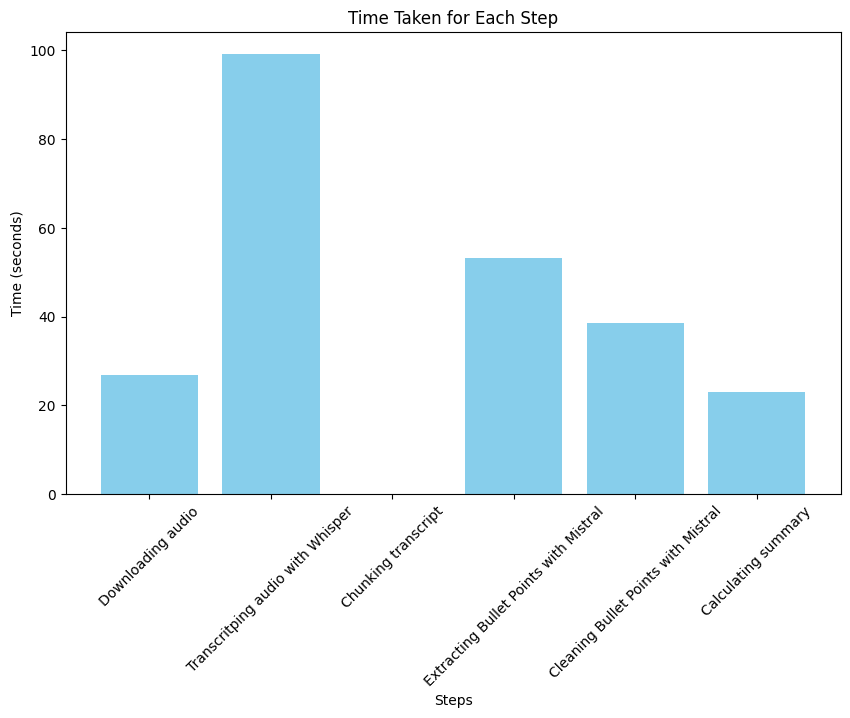

In [9]:
# Print the summary extracted
with open("summary.txt", "r") as summary_file:
    summary = summary_file.read()
    print("Summary Extracted:\n")
    print(summary)

# Display time per step in a bar chart
steps = list(time_dict.keys())
times = list(time_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(steps, times, color='skyblue')
plt.xlabel('Steps')
plt.ylabel('Time (seconds)')
plt.title('Time Taken for Each Step')
plt.xticks(rotation=45)
plt.show()